In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))

In [1]:
import numpy as np 
import torch
import torchvision
import matplotlib.pyplot as plt

import datasets.mnist as mnist
import datasets.cifar10 as cifar10
import constants
from configuration import Configuration

from util import *

In [2]:
# on the cblgpu08 computer

# different methods
checkpoints = [('run-20210514_191847-3u588wxi', 'NC Ens 3, reg 0.5'), ('run-20210514_192309-2rlfhitc', 'Ens 3'),
('run-20210514_192736-3q5el7rl', 'MC drop 3, rate 0.5'), ('run-20210514_193101-nyehd80r', 'Single')]

# different NC weight
# checkpoints = [('run-20210514_191847-3u588wxi', 'NCEns 3, reg 0.5'), ('run-20210514_223116-3tusc1ni', 'NCEns 3, reg 0.1'),
# ('run-20210514_223603-1ogek1sb', 'NCEns 3, reg 0.3'), ('run-20210514_224048-14iqxlw4', 'NCEns 3, reg 0.7'),
# ('run-20210514_224531-375asb5u', 'NCEns 3, reg 1'), ('run-20210514_225017-aiy9lfbx', 'NCEns 3, reg 2')] 

In [1]:
# for MNIST
checkpoint_epoch = 20
corruption_intensity = 60
thresholds = np.linspace(0, 1, 50)
entropy_bins = np.linspace(-1, 2.5, 100)

res = []

for run_id, name in checkpoints:

    trainer, model_args = load_trainer(run_id, checkpoint_epoch, device='cpu')

    test_loader = mnist.get_test_loader(model_args.data_dir, model_args.batch_size, corrupted=True, intensity=corruption_intensity, corruption='rotation')


    metric_dict = {'NLL': lambda p, g: metrics.basic_cross_entropy(p, g).item(), 
                    'ECE': metrics.wrap_ece(bins=20), 
                    'Brier': metrics.wrap_brier()}

    # acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies, _, _ = trainer.test(test_loader=test_loader, metric_dict=metric_dict, confidence_thresholds=thresholds, entropy_bins=entropy_bins)
    acc, metric_res, stat_tracker = trainer.test(test_loader=test_loader, metric_dict=metric_dict, confidence_thresholds=thresholds, entropy_bins=entropy_bins)
    thresholded_accuracies, thresholded_counts = stat_tracker.get_counts_acc_by_confidence()
    binned_entropies = stat_tracker.get_binned_entropies()

    res.append((name, acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies))

NameError: name 'np' is not defined

Text(0.5, 1.0, 'Accuracy vs Confidence. Rotation, intensity 4')

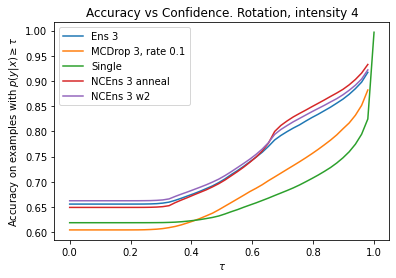

In [5]:
plt.figure(figsize=(15, 5))
plt.subplot(121)

for name, acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies in res:
    plt.plot(thresholds, thresholded_accuracies, label=name)
plt.xlabel(r'$\tau$')
plt.ylabel(r'Accuracy on examples with $p(y|x) \geq \tau$')
plt.legend()
plt.title(f'Accuracy vs Confidence. Rotation, intensity {corruption_intensity}')

plt.subplot(122)
for name, acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies in res:
    plt.plot(thresholds, thresholded_counts, label=name)
plt.xlabel(r'$\tau$')
plt.ylabel(r'Count of examples with $p(y|x) \geq \tau$')
plt.legend()
plt.title(f'Count vs Confidence. Rotation, intensity {corruption_intensity}')

Text(0.5, 1.0, 'Count vs Confidence. Rotation, intensity 4')

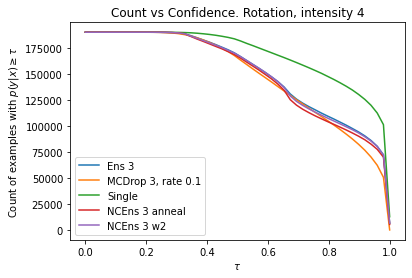

Ens 3
55104.0
MCDrop 3, rate 0.1
28967.0
Single
78220.0
NCEns 3 anneal
54102.0
NCEns 3 w2
55789.0


Text(0.5, 1.0, 'Count vs Entropy. Rotation, intensity 4')

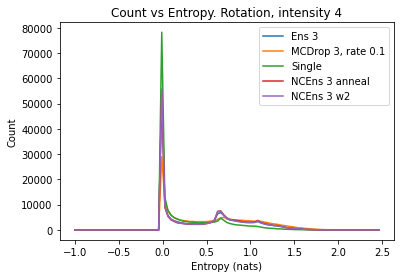

In [8]:
for name, acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies in res:
    plt.plot(entropy_bins[:-1], binned_entropies, label=name)
    print(name)
    print(max(binned_entropies))
plt.xlabel(r'Entropy (nats)')
plt.ylabel(r'Count')
plt.legend()
plt.title(f'Count vs Entropy. Rotation, intensity {corruption_intensity}')

## OOD Data

In [17]:
# for CIFAR
thresholds = np.linspace(0, 1, 50)
entropy_bins = np.linspace(-1, 2.5, 100) # since only entropy really makes sense

res_ood = []

for run_id, name in checkpoints:

    trainer, model_args = load_trainer(run_id, checkpoint_epoch, device='cpu')

    test_set = torchvision.datasets.FashionMNIST(root=constants.DATA_DIR, split='train', download=True, transform=torchvision.transforms.ToTensor())
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=128)


    metric_dict = {'NLL': lambda p, g: metrics.basic_cross_entropy(p, g).item(), 
                    'ECE': metrics.wrap_ece(bins=20), 
                    'Brier': metrics.wrap_brier()}

    acc, metric_res, stat_tracker = trainer.test(test_loader=test_loader, metric_dict=metric_dict, confidence_thresholds=thresholds, entropy_bins=entropy_bins)
    thresholded_accuracies, thresholded_counts = stat_tracker.get_counts_acc_by_confidence()
    binned_entropies = stat_tracker.get_binned_entropies()

    res_ood.append((name, acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies))

Initialising an ensemble of 3 networks
SGD optimizer


  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?batch/s]/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/homes/gp491/deepens/metrics.py:230: UserWarning: Warning: converting a masked element to nan.
  accuracies[i] = np.ma.masked_array(eq, mask=~mask).mean(-1)
  0%|          | 1/573 [00:00<01:19,  7.20batch/s]
Testing
100%|██████████| 573/573 [01:12<00:00,  7.94batch/s]
Results: 
Accuracy: 0.10793507787651692
NLL: 5.453151104740108
ECE: 0.4080395604956672
Brier: 1.1790135065900027
SGD optimizer
using multistep sched

Ens 3
7029.0
MCDrop 3, rate 0.1
5670.0
Single
6103.0
NCEns 3 anneal
6527.0
NCEns 3 w2
7996.0


Text(0.5, 1.0, 'Count vs Entropy. OOD dataset.')

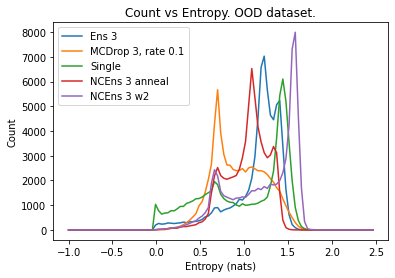

In [20]:
for name, acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies in res_ood:
    plt.plot(entropy_bins[:-1], binned_entropies, label=name)
    print(name)
    print(max(binned_entropies))
plt.xlabel(r'Entropy (nats)')
plt.ylabel(r'Count')
plt.legend()
plt.title(f'Count vs Entropy. OOD dataset.')

Text(0.5, 1.0, 'Count vs Confidence. OOD Data')

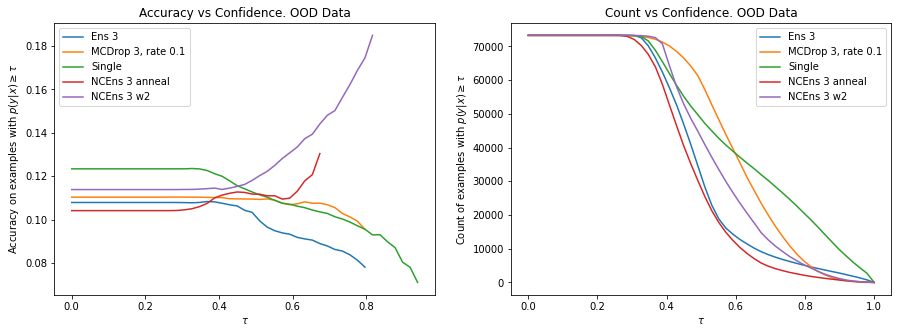

In [21]:
plt.figure(figsize=(15, 5))

plt.subplot(121)

for name, acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies in res_ood:
    plt.plot(thresholds, thresholded_accuracies, label=name)
plt.xlabel(r'$\tau$')
plt.ylabel(r'Accuracy on examples with $p(y|x) \geq \tau$')
plt.legend()
plt.title(f'Accuracy vs Confidence. OOD Data')

plt.subplot(122)
for name, acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies in res_ood:
    plt.plot(thresholds, thresholded_counts, label=name)
plt.xlabel(r'$\tau$')
plt.ylabel(r'Count of examples with $p(y|x) \geq \tau$')
plt.legend()
plt.title(f'Count vs Confidence. OOD Data')

## Similarity Study

In [10]:
checkpoint_epoch = 40
device='cpu'

### Cross-entropy regularised

In [2]:
run_id, name = 'run-20210611_184046-icusri5l', 'ceens w0.7'

In [12]:
trainer, model_args = load_trainer(run_id, checkpoint_epoch, device)

test_loader = mnist.get_test_loader(model_args.data_dir, model_args.batch_size, corrupted=False, intensity=60, corruption='rotation')


metric_dict = {'NLL': lambda p, g: metrics.basic_cross_entropy(p, g).item(), 
                'ECE': metrics.wrap_ece(bins=20), 
                'Brier': metrics.wrap_brier()}

# acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies, disagreement_mat, calibration_hist = trainer.test(test_loader=test_loader, metric_dict=metric_dict, track_full_disagreements=True, calibration_hist_bins=15)
acc, metric_res, stat_tracker = trainer.test(test_loader=test_loader, metric_dict=metric_dict, track_full_disagreements=True, calibration_hist_bins=15)
thresholded_accuracies, thresholded_counts = stat_tracker.get_counts_acc_by_confidence()
binned_entropies = stat_tracker.get_binned_entropies()
disagreement_mat = stat_tracker.get_disagreement_mat()
calibration_hist = stat_tracker.get_calibration_hist()

test_loader = mnist.get_test_loader(model_args.data_dir, model_args.batch_size, corrupted=True, intensity=60, corruption='rotation')

acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies, disagreement_mat_rot, calibration_hist_rot = trainer.test(test_loader=test_loader, metric_dict=metric_dict, track_full_disagreements=True, calibration_hist_bins=15)


  0%|          | 0/79 [00:00<?, ?batch/s]Initialising a pairwise cross-entropy regularised ensemble of 10 networks

Testing
  0%|          | 0/79 [00:00<?, ?batch/s]Results: 
Accuracy: 0.9903
NLL: 0.030038800263404847
ECE: 0.015533953225612641
Brier: 0.015019478350877762

Testing
100%|██████████| 79/79 [00:03<00:00, 24.33batch/s]Results: 
Accuracy: 0.2593
NLL: 3.25558967666626
ECE: 0.4391496034383774
Brier: 1.090621244239807



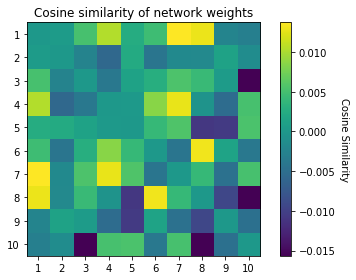

In [13]:
mat = plot_cosine_similarity(trainer, remove_diag=True)

#### Original Test Set

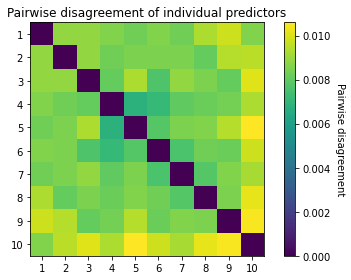

In [14]:
plot_disagreement_mat(disagreement_mat)

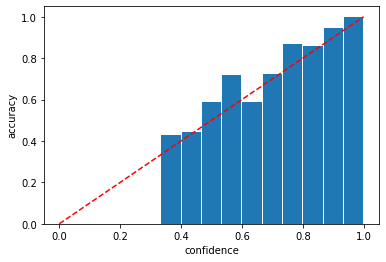

In [15]:
plot_calibration_hist(calibration_hist)

#### Rotated Test

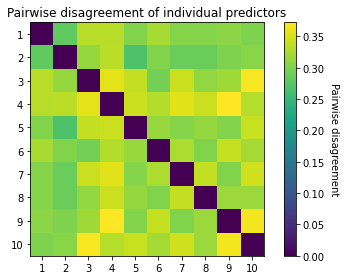

In [16]:
plot_disagreement_mat(disagreement_mat_rot)

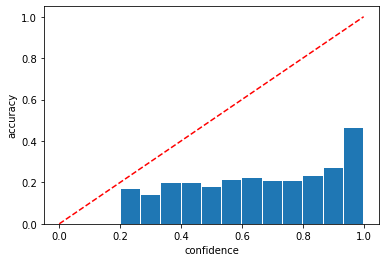

In [17]:
plot_calibration_hist(calibration_hist_rot)

### Negative Correlation Ensemble, Weight 5

In [32]:
run_id, name = 'run-20210611_180115-4ev15ecj', 'ncens-w5'

In [33]:
trainer, model_args = load_trainer(run_id, checkpoint_epoch, device)

test_loader = mnist.get_test_loader(model_args.data_dir, model_args.batch_size, corrupted=False, intensity=60, corruption='rotation')


metric_dict = {'NLL': lambda p, g: metrics.basic_cross_entropy(p, g).item(), 
                'ECE': metrics.wrap_ece(bins=20), 
                'Brier': metrics.wrap_brier()}

# acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies, disagreement_mat, calibration_hist = trainer.test(test_loader=test_loader, metric_dict=metric_dict, track_full_disagreements=True, calibration_hist_bins=15)
acc, metric_res, stat_tracker = trainer.test(test_loader=test_loader, metric_dict=metric_dict, track_full_disagreements=True, calibration_hist_bins=15)
thresholded_accuracies, thresholded_counts = stat_tracker.get_counts_acc_by_confidence()
binned_entropies = stat_tracker.get_binned_entropies()
disagreement_mat = stat_tracker.get_disagreement_mat()
calibration_hist = stat_tracker.get_calibration_hist()

test_loader = mnist.get_test_loader(model_args.data_dir, model_args.batch_size, corrupted=True, intensity=60, corruption='rotation')

# acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies, disagreement_mat_rot, calibration_hist_rot = trainer.test(test_loader=test_loader, metric_dict=metric_dict, track_full_disagreements=True, calibration_hist_bins=15)
acc, metric_res, stat_tracker = trainer.test(test_loader=test_loader, metric_dict=metric_dict, track_full_disagreements=True, calibration_hist_bins=15)
thresholded_accuracies, thresholded_counts = stat_tracker.get_counts_acc_by_confidence()
binned_entropies = stat_tracker.get_binned_entropies()
disagreement_mat_rot = stat_tracker.get_disagreement_mat()
calibration_hist_rot = stat_tracker.get_calibration_hist()

  0%|          | 0/79 [00:00<?, ?batch/s]Initialising a negative-correlation normalised ensemble of 10 networks

Testing
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
  0%|          | 0/79 [00:00<?, ?batch/s]Results: 
Accuracy: 0.9907
NLL: 0.34159266653060916
ECE: 0.27329949066340925
Brier: 0.11698526649475098

Testing
100%|██████████| 79/79 [00:03<00:00, 25.16batch/s]Results: 
Accuracy: 0.253
NLL: 3.08831198387146
ECE: 0.30889114225804803
Brier: 0.9712562324523926



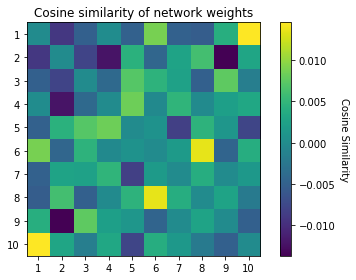

In [34]:
mat = plot_cosine_similarity(trainer, remove_diag=True)

#### Original Test

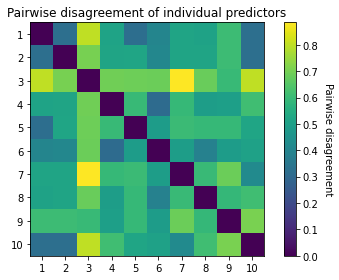

In [35]:
plot_disagreement_mat(disagreement_mat)

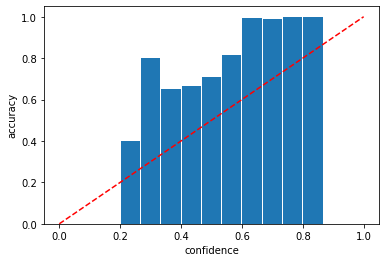

In [36]:
plot_calibration_hist(calibration_hist)

#### Rotated Test

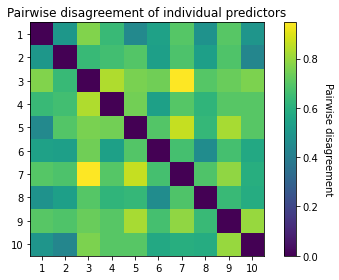

In [37]:
plot_disagreement_mat(disagreement_mat_rot)

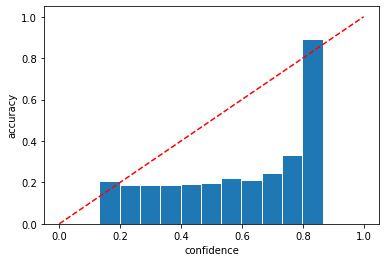

In [38]:
plot_calibration_hist(calibration_hist_rot)

### Ensemble

In [39]:
run_id, name = 'run-20210611_173106-7zkjrtet', 'ens'

In [40]:
trainer, model_args = load_trainer(run_id, checkpoint_epoch, device)

test_loader = mnist.get_test_loader(model_args.data_dir, model_args.batch_size, corrupted=False, intensity=60, corruption='rotation')


metric_dict = {'NLL': lambda p, g: metrics.basic_cross_entropy(p, g).item(), 
                'ECE': metrics.wrap_ece(bins=20), 
                'Brier': metrics.wrap_brier()}

# acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies, disagreement_mat, calibration_hist = trainer.test(test_loader=test_loader, metric_dict=metric_dict, track_full_disagreements=True, calibration_hist_bins=15)
acc, metric_res, stat_tracker = trainer.test(test_loader=test_loader, metric_dict=metric_dict, track_full_disagreements=True, calibration_hist_bins=15)
thresholded_accuracies, thresholded_counts = stat_tracker.get_counts_acc_by_confidence()
binned_entropies = stat_tracker.get_binned_entropies()
disagreement_mat = stat_tracker.get_disagreement_mat()
calibration_hist = stat_tracker.get_calibration_hist()

test_loader = mnist.get_test_loader(model_args.data_dir, model_args.batch_size, corrupted=True, intensity=60, corruption='rotation')

# acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies, disagreement_mat_rot, calibration_hist_rot = trainer.test(test_loader=test_loader, metric_dict=metric_dict, track_full_disagreements=True, calibration_hist_bins=15)
acc, metric_res, stat_tracker = trainer.test(test_loader=test_loader, metric_dict=metric_dict, track_full_disagreements=True, calibration_hist_bins=15)
thresholded_accuracies, thresholded_counts = stat_tracker.get_counts_acc_by_confidence()
binned_entropies = stat_tracker.get_binned_entropies()
disagreement_mat_rot = stat_tracker.get_disagreement_mat()
calibration_hist_rot = stat_tracker.get_calibration_hist()

  0%|          | 0/79 [00:00<?, ?batch/s]Initialising an ensemble of 10 networks

Testing
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
  0%|          | 0/79 [00:00<?, ?batch/s]Results: 
Accuracy: 0.9902
NLL: 0.02734549372475594
ECE: 0.013708920702338218
Brier: 0.014231802982091904

Testing
100%|██████████| 79/79 [00:03<00:00, 24.59batch/s]Results: 
Accuracy: 0.2641
NLL: 3.463681505203247
ECE: 0.4548718614086509
Brier: 1.1014914365768433



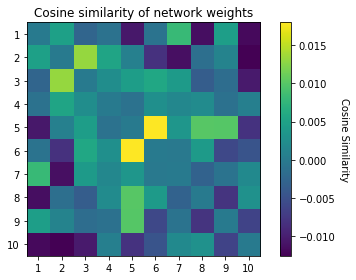

In [41]:
mat = plot_cosine_similarity(trainer, remove_diag=True)

#### Original Testm

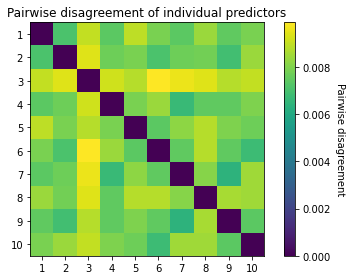

In [43]:
plot_disagreement_mat(disagreement_mat)

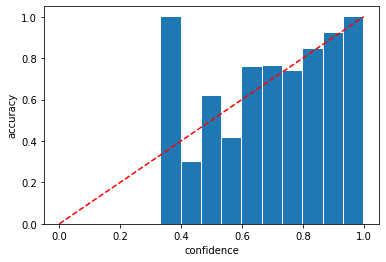

In [42]:
plot_calibration_hist(calibration_hist)

#### Rotated Test

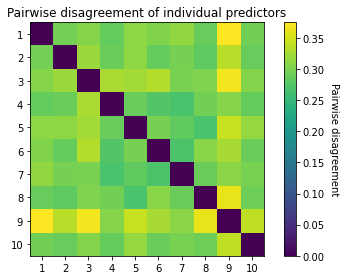

In [44]:
plot_disagreement_mat(disagreement_mat_rot)

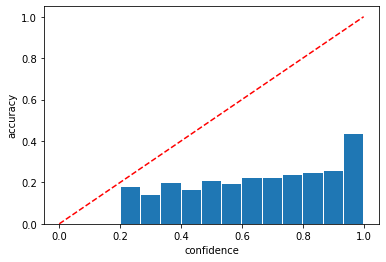

In [45]:
plot_calibration_hist(calibration_hist_rot)